## Install Dependencies

In [2]:
from IPython.display import clear_output
!pip install –upgrade pip
!pip install torch
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install torchvision
!pip install opencv-python
!pip install cv2
clear_output()

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
# import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import gc

# from mlxtend.plotting import plot_confusion_matrix
# from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Data Processing

In [5]:
path = '../data/chest_xray/chest_xray'

In [6]:
transformer = {
    'dataset1': transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(),
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor()
                                           ]),
    
    'dataset2' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=1),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                                            transform.ToTensor()
                                    
                                           ]),
    'dataset3' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=0.5),
                                            transform.RandomRotation(15),
                                            transform.RandomGrayscale(p=1),
                                            transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                                            transform.ToTensor()
                                           ]),
}

In [7]:
dataset1 = ImageFolder('data/chest_xray/chest_xray/train', 
                      transform=transformer['dataset1'])

dataset2 = ImageFolder('data/chest_xray/chest_xray/train', 
                      transform=transformer['dataset2'])

dataset3 = ImageFolder('data/chest_xray/chest_xray/train', 
                      transform=transformer['dataset3'])

norm1, _ = train_test_split(dataset2, test_size= 3875/(1341+3875), shuffle=False)
norm2, _ = train_test_split(dataset3, test_size= 4023/(1341+3875), shuffle=False)

dataset = ConcatDataset([dataset1, norm1, norm2])

In [8]:
random_seed = 2020
torch.manual_seed(random_seed);
train_ds, val_ds = train_test_split(dataset, test_size=0.3, random_state=random_seed)
len(train_ds), len(val_ds)

(5425, 2325)

In [9]:
batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

## Model 

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [11]:
model = torchvision.models.densenet161(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier.in_features

model.classifier = nn.Linear(in_features, 2)

In [13]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

## Training Model

In [14]:
def train(model, criterion, optimizer, scheduler, epochs):
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
      
            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outp = model(inputs)
                    _, pred = torch.max(outp, 1)
                    loss = criterion(outp, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if phase == 'train':
                print('Epoch: {}/{}'.format(epoch+1, epochs))
                print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            scheduler.step()  
    time_elapsed = time.time() - since
    print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
    print('Best accuracy {}'.format(best_acc))

    model.load_state_dict(best_model)
    return model   

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

In [16]:
model.to(device)
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.2896675151119584, accuracy0.896774193548387
Time: 0.0m 53.24266695976257s
Epoch: 2/10
train - loss:0.15600460740759076, accuracy0.9447004608294931
Time: 1.0m 44.19484519958496s
Epoch: 3/10
train - loss:0.13539428920377783, accuracy0.9559447004608295
Time: 2.0m 35.601651430130005s
Epoch: 4/10
train - loss:0.12914616085966613, accuracy0.9574193548387097
Time: 3.0m 27.30038595199585s
Epoch: 5/10
train - loss:0.12612835740850817, accuracy0.9566820276497696
Time: 4.0m 19.144429922103882s
Epoch: 6/10
train - loss:0.12703108531538793, accuracy0.9570506912442396
Time: 5.0m 10.970044136047363s
Epoch: 7/10
train - loss:0.1203937387452697, accuracy0.9607373271889401
Time: 6.0m 2.6899185180664062s
Epoch: 8/10
train - loss:0.12776818778108343, accuracy0.9581566820276498
Time: 6.0m 54.086814880371094s
Epoch: 9/10
train - loss:0.1266072211672084, accuracy0.9564976958525345
Time: 7.0m 44.52982759475708s
Epoch: 10/10
train - loss:0.12907067742284542, accuracy0.959447004608294

## Attacks

In [17]:
!pip install captum
!pip install cleverhans
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import GradientShap
from captum.attr import GuidedGradCam
from captum.attr import LimeBase
from captum.attr import KernelShap
from captum.attr import Occlusion
from captum.attr import visualization as viz
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent
)
clear_output()

## Statsitical Methods

In [18]:
def compute_mean_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        avg = np.mean(a)
        deviation = a - avg 
        absolute_deviation = np.abs(deviation)
        result = np.mean(absolute_deviation)
        scores.append(result)
    return scores    
def compute_median_abs_dev(attr): 
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        med = np.median(a)
        deviation = a - med 
        abs_deviation = np.abs(deviation)
        result = np.median(abs_deviation)
        scores.append(result)
    return scores 
def compute_iqr(attr):
    #inter-quartile range
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = score_75 - score_25
        scores.append(score_qt)
    return scores
    
def compute_coef_var(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        m = np.mean(a)
        st = np.std(attr[i])
        sc = m/st
        scores.append(sc)
    return scores

def compute_coef_iqr(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        score_75 = np.percentile(a, 75)
        score_25 = np.percentile(a, 25)
        score_qt = (score_75 - score_25)/(score_75 + score_25)
        scores.append(score_qt)
    return scores
    

In [19]:
eps = [8/255, 16/255, 32/255, 64/255]

## PGD & Integrated Gradient

## Benign Images To Find Threshold

In [25]:
gc.collect()
torch.cuda.empty_cache()

dataiter = iter(train_dl)
ig = IntegratedGradients(model)

igmedianAbs_ben = []
igmeanAbs_ben = []
igiqr_ben = []
igcoef_var_ben=[]
igcoef_iqr_ben = []

for i in range(30):
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    for ind in range(32):
        gc.collect()
        torch.cuda.empty_cache()
        input1 = images[ind].unsqueeze(0)
        x_logits = model(images)
        a_batch_benign = ig.attribute(input1, target=labels[ind]).sum(axis=1).cpu().detach().numpy()
        igmeanAbs_ben += compute_mean_abs_dev(a_batch_benign)
        igmedianAbs_ben += compute_median_abs_dev(a_batch_benign)
        igiqr_ben += compute_iqr(a_batch_benign)
        igcoef_var_ben += compute_coef_var(a_batch_benign)
        igcoef_iqr_ben += compute_coef_iqr(a_batch_benign)
        gc.collect()
        torch.cuda.empty_cache()


In [ ]:
gc.collect()
torch.cuda.empty_cache()

dataiter1 = iter(val_dl)

testigmedianAbs_ben = []
testigmeanAbs_ben = []
testigiqr_ben = []
testigcoef_var_ben=[]
testigcoef_iqr_ben = []

testigmedianAbs_bena = []
testigmeanAbs_bena = []
testigiqr_bena = []
testigcoef_var_bena=[]
testigcoef_iqr_bena = []

for ep in eps:
    igmedianAbs_ben = []
    igmeanAbs_ben = []
    igiqr_ben = []
    igcoef_var_ben=[]
    igcoef_iqr_ben = []

    igmedianAbs_bena = []
    igmeanAbs_bena = []
    igiqr_bena = []
    igcoef_var_bena=[]
    igcoef_iqr_bena = []
    for i in range(10):
        images, labels = next(dataiter1)
        images = images.to(device)
        labels = labels.to(device)
        for ind in range(32):
            gc.collect()
            torch.cuda.empty_cache()
            input1 = images[ind].unsqueeze(0)
            x_logits = model(images)
            a_batch_benign = ig.attribute(input1, target=labels[ind]).sum(axis=1).cpu().detach().numpy()
            igmeanAbs_ben += compute_mean_abs_dev(a_batch_benign)
            igmedianAbs_ben += compute_median_abs_dev(a_batch_benign)
            igiqr_ben += compute_iqr(a_batch_benign)
            igcoef_var_ben += compute_coef_var(a_batch_benign)
            igcoef_iqr_ben += compute_coef_iqr(a_batch_benign)
            alpha = ep/10
            steps = int(alpha*ep)
            images_pgd = projected_gradient_descent(model, input1, ep, alpha, steps, np.inf)
            _, y_pred_pgd = model(images_pgd).max(1)
            a_batch_attack = ig.attribute(inputs=images_pgd, target=y_pred_pgd).sum(axis=1).cpu().detach().numpy()
            igmeanAbs_bena += compute_mean_abs_dev(a_batch_attack)
            igmedianAbs_bena += compute_median_abs_dev(a_batch_attack)
            igiqr_bena += compute_iqr(a_batch_attack)
            igcoef_var_bena += compute_coef_var(a_batch_attack)
            igcoef_iqr_bena += compute_coef_iqr(a_batch_attack)
            gc.collect()
            torch.cuda.empty_cache()
    testigmedianAbs_ben.append(igmedianAbs_ben)
    testigmeanAbs_ben.append(igmeanAbs_ben)
    testigiqr_ben.append(igiqr_ben)
    testigcoef_var_ben.append(igcoef_var_ben)
    testigcoef_iqr_ben.append(igcoef_iqr_ben)

    testigmedianAbs_bena.append(igmedianAbs_bena)
    testigmeanAbs_bena.append(igmeanAbs_ben)
    testigiqr_bena.append(igiqr_bena)
    testigcoef_var_bena.append(igcoef_var_bena)
    testigcoef_iqr_bena.append(igcoef_iqr_bena)


### Median Abs Deviation

In [ ]:
min(igmedianAbs_ben), max(igmedianAbs_ben)

igmedt1 = []
igmedt2 = []
fpr = []
tpr = []
for x, y in zip(igmedt1, igmedt2):
    

### Mean Abs Deviation

In [ ]:
min(igmedianAbs_ben), max(igmedianAbs_ben)

## PGD & Saliency

/opt/conda/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


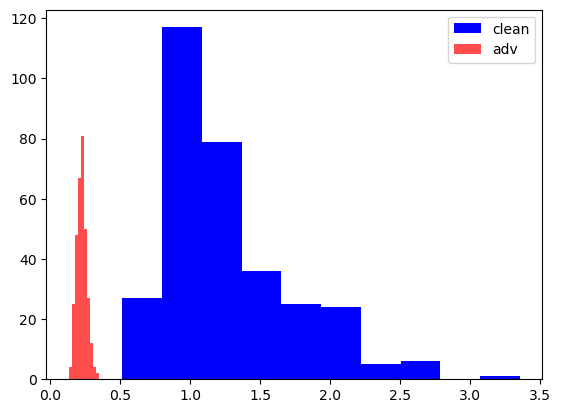

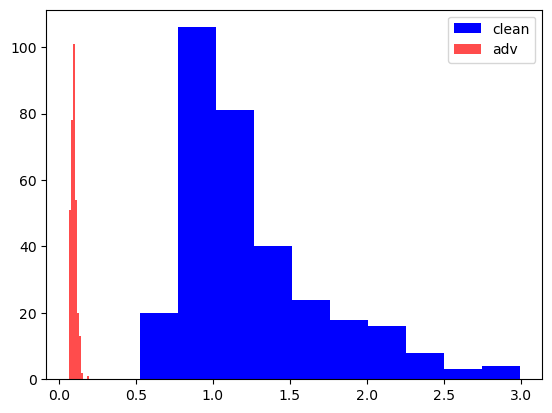

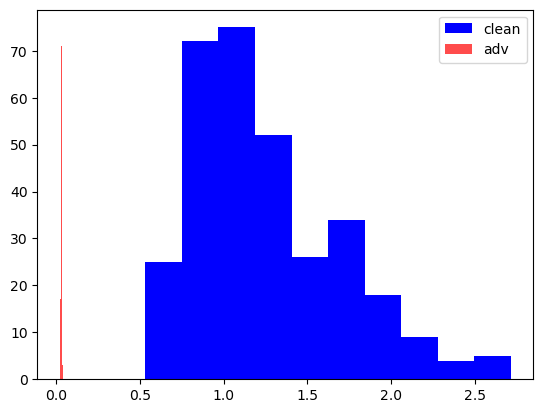

IndexError: index 21 is out of bounds for dimension 0 with size 21

In [21]:
gc.collect()
torch.cuda.empty_cache()

dataiter = iter(val_dl)

for ep in eps:
    salmedianAbs_ben = []
    salmeanAbs_ben = []
    saliqr_ben = []
    salcoef_var_ben=[]
    salcoef_iqr_ben = []

    salmedianAbs_bena = []
    salmeanAbs_bena = []
    saliqr_bena = []
    salcoef_var_bena=[]
    salcoef_iqr_bena = []
    for i in range(10):
        images, labels = next(dataiter)
        images = images.to(device)
        labels = labels.to(device)
        for ind in range(32):
            gc.collect()
            torch.cuda.empty_cache()
            input1 = images[ind].unsqueeze(0)
            x_logits = model(images)
            ig = Saliency(model)
            a_batch_benign = ig.attribute(input1, target=labels[ind]).sum(axis=1).cpu().detach().numpy()
            salmeanAbs_ben += compute_mean_abs_dev(a_batch_benign)
            salmedianAbs_ben += compute_median_abs_dev(a_batch_benign)
            saliqr_ben += compute_iqr(a_batch_benign)
            salcoef_var_ben += compute_coef_var(a_batch_benign)
            salcoef_iqr_ben += compute_coef_iqr(a_batch_benign)
            alpha = ep/10
            steps = int(alpha*ep)
            images_pgd = projected_gradient_descent(model, input1, ep, alpha, steps, np.inf)
            _, y_pred_pgd = model(images_pgd).max(1)
            a_batch_attack = ig.attribute(inputs=images_pgd, target=y_pred_pgd).sum(axis=1).cpu().detach().numpy()
            salmeanAbs_bena += compute_mean_abs_dev(a_batch_attack)
            salmedianAbs_bena += compute_median_abs_dev(a_batch_attack)
            saliqr_bena += compute_iqr(a_batch_attack)
            salcoef_var_bena += compute_coef_var(a_batch_attack)
            salcoef_iqr_bena += compute_coef_iqr(a_batch_attack)
            gc.collect()
            torch.cuda.empty_cache()
    plt.hist(saliqr_ben, label='clean', color='blue')
    plt.hist(saliqr_bena, label='adv', alpha=0.7, color='red')
    plt.legend()
    plt.show()


## PGD & GraidentSHAP

/tmp/ipykernel_21/890496051.py:38: RuntimeWarning: invalid value encountered in scalar divide
  sc = m/st
/tmp/ipykernel_21/890496051.py:48: RuntimeWarning: invalid value encountered in scalar divide
  score_qt = (score_75 - score_25)/(score_75 + score_25)


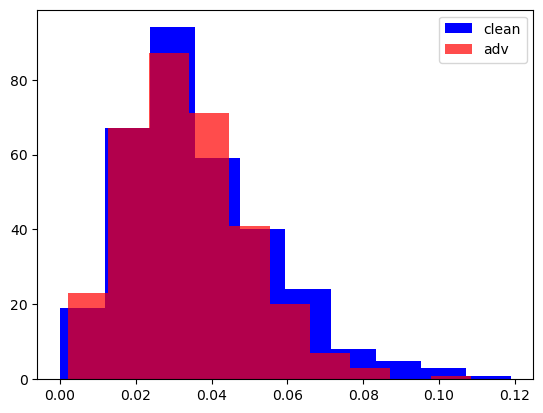

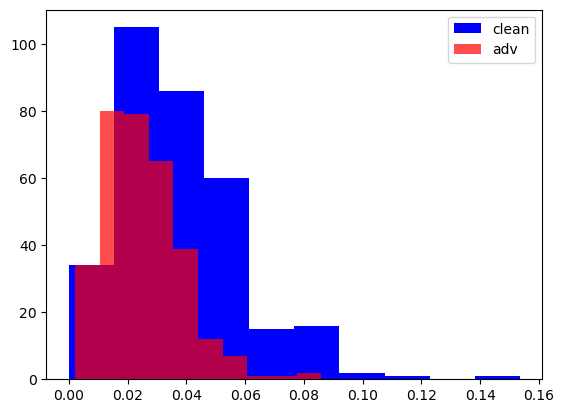

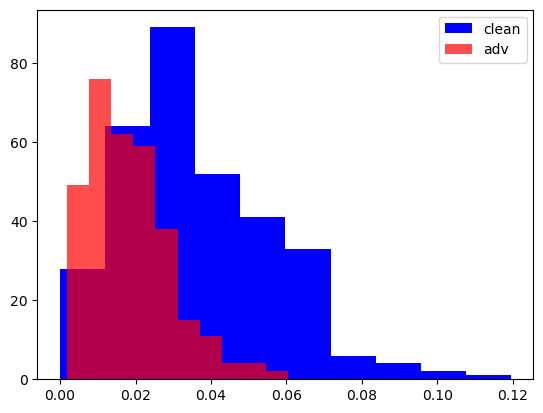

IndexError: index 21 is out of bounds for dimension 0 with size 21

In [22]:
gc.collect()
torch.cuda.empty_cache()

dataiter = iter(val_dl)

for ep in eps:
    gradmedianAbs_ben = []
    gradmeanAbs_ben = []
    gradiqr_ben = []
    gradcoef_var_ben=[]
    gradcoef_iqr_ben = []

    gradmedianAbs_bena = []
    gradmeanAbs_bena = []
    gradiqr_bena = []
    gradcoef_var_bena=[]
    gradcoef_iqr_bena = []
    for i in range(10):
        images, labels = next(dataiter)
        images = images.to(device)
        labels = labels.to(device)
        for ind in range(32):
            gc.collect()
            torch.cuda.empty_cache()
            input1 = images[ind].unsqueeze(0)
            x_logits = model(images)
            ig = GradientShap(model)
            rand_img_dist = torch.cat([input1 * 0, input1 * 1])
            a_batch_benign = ig.attribute(input1, target=labels[ind],baselines=rand_img_dist).sum(axis=1).cpu().detach().numpy()
            gradmeanAbs_ben += compute_mean_abs_dev(a_batch_benign)
            gradmedianAbs_ben += compute_median_abs_dev(a_batch_benign)
            gradiqr_ben += compute_iqr(a_batch_benign)
            gradcoef_var_ben += compute_coef_var(a_batch_benign)
            gradcoef_iqr_ben += compute_coef_iqr(a_batch_benign)
            alpha = ep/10
            steps = int(alpha*ep)
            images_pgd = projected_gradient_descent(model, input1, ep, alpha, steps, np.inf)
            _, y_pred_pgd = model(images_pgd).max(1)
            a_batch_attack = ig.attribute(inputs=images_pgd, target=y_pred_pgd,baselines=rand_img_dist).sum(axis=1).cpu().detach().numpy()
            gradmeanAbs_bena += compute_mean_abs_dev(a_batch_attack)
            gradmedianAbs_bena += compute_median_abs_dev(a_batch_attack)
            gradiqr_bena += compute_iqr(a_batch_attack)
            gradcoef_var_bena += compute_coef_var(a_batch_attack)
            gradcoef_iqr_bena += compute_coef_iqr(a_batch_attack)
            gc.collect()
            torch.cuda.empty_cache()
    plt.hist(gradmedianAbs_ben, label='clean', color='blue')
    plt.hist(gradmedianAbs_bena, label='adv', alpha=0.7, color='red')
    plt.legend()
    plt.show()
